In [51]:
import pandas as pd 
# default='warn', Used here to supress warning when slicing and creating high earners column
pd.options.mode.chained_assignment = None 


In [52]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle

In [53]:
#Load machine learning model
model = pickle.load(open('model_be.pkl', 'rb'))

#### Getting data from the API

In [54]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/be/first-division-a/2019-2020/'

# Retrieve json
json1 = requests.get(endpoint, headers = headers).text

#Data for 2019/2020
df1 = pd.read_json(json1)


df1 = df1[df1["season_term"] == "combined"]

In [55]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/be/first-division-a/2020-2021/'

# Retrieve json
json2 = requests.get(endpoint, headers=headers).text

#Data for 2020/2021
df2 = pd.read_json(json2)


df2 = df2[df2["season_term"] == "combined"]

In [56]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/be/first-division-a/2021-2022/'

# Retrieve json
json3 = requests.get(endpoint, headers=headers).text

#Data for 2021/2022
df3 = pd.read_json(json3)


df3 = df3[df3["season_term"] == "combined"]

In [57]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/be/first-division-a/2022-2023/'

# Retrieve json
json4 = requests.get(endpoint, headers=headers).text

#Data for 2022/2023
df4 = pd.read_json(json4)

#Capology has defined the seson as summer
df4 = df4[df4["season_term"] == "summer"]

In [58]:
df = pd.concat([df1,df2,df3,df4],axis = 0).drop_duplicates()

#### Cleaning Data frame

In [59]:
df = df[df['salary_gross_eur'] != 0]

In [60]:
CODE_DICT = pd.Series(df.club_code.values,index=df.club_name).to_dict()


In [61]:
#Required columns
LIST = ['season_id','club_code','player_age','player_country_id','player_group_code','salary_gross_eur']

In [62]:
global df_salary
df_salary = df[LIST]
df_salary = df_salary.reset_index(drop = True)

In [63]:
df_salary.head()

,season_id,club_code,player_age,player_country_id,player_group_code,salary_gross_eur
0,2019-2020,AND,28,france,M,2000000
1,2019-2020,AND,20,belgium,M,130000
2,2019-2020,AND,26,honduras,D,1170000
3,2019-2020,AND,17,belgium,F,80000
4,2019-2020,AND,32,belgium,D,20000


#### Finding High Earners

In [64]:
# Group the data by 'club' and 'position'
groups = df_salary.groupby(['season_id','club_code', 'player_group_code'])
# Find the highest two values of column 'salary_gross_eur' for each group
top_two = groups['salary_gross_eur'].nlargest(2).reset_index()

# get needed indexes
index = list(top_two['level_3'])

# Add the result to the data frame as a new column
df_salary['high_earner'] = 0
for i in index:
    df_salary.loc[i, 'high_earner'] = 1

#### Creating  needed features

In [81]:
# Final league standings
standings_2019 = ['BRU','GNT','CHL','ATW','STL','MEC','GEK','AND','ZUW','EXM','KOR','SIT','EUP','CER','OOS','BEV']
standings_2020 = ['BRU','ATW','AND','GEK','OOS','STL','GNT','MEC','BEE','ZUW','LEU','EUP','CHL','KOR','SIT','CER','BEV','EXM']
standings_2021 = ['USG','BRU','AND','ATW','GNT','CHL','MEC','GEK','SIT','CER','LEU','OOS','KOR','STL','EUP','ZUW','SER','BEE']

#Current league standings
standings_2022 = ['GEK','USG','ATW','BRU','GNT','WES','STL','LEU','CER','SIT','AND','CHL','MEC','OOS','EUP','ZUW','KOR','SER']

In [66]:
def set_club_type(row):
    
    """
    Function takes each row as argument and returns
    top 2,top 5,mid-table, relagation based on the club 
    finishing position for the year
    
    """

    if (row['club_code'] in standings_2019[:2] and row['season_id']== '2019-2020') or (row['club_code'] in standings_2020[0:2] and row['season_id']=='2020-2021') or (row['club_code'] in standings_2021[0:2] and row['season_id']=='2021-2022') or (row['club_code'] in standings_2022[0:2] and row['season_id']=='2022-2023'):
        return 'top 2'
   
    if (row['club_code'] in standings_2019[2:5] and row['season_id']== '2019-2020') or (row['club_code'] in standings_2020[2:5] and row['season_id']=='2020-2021') or (row['club_code'] in standings_2021[2:5] and row['season_id']=='2021-2022') or (row['club_code'] in standings_2022[2:5] and row['season_id']=='2022-2023'):
        return 'top 5'
    
    if (row['club_code'] in standings_2019[5:15] and row['season_id']== '2019-2020') or (row['club_code'] in standings_2020[5:16] and row['season_id']=='2020-2021') or (row['club_code'] in standings_2021[5:16] and row['season_id']=='2021-2022') or (row['club_code'] in standings_2022[5:16] and row['season_id']=='2022-2023'):
        return 'mid-table'
    
    else :
        return 'relegation'


In [67]:
countries = df_salary.player_country_id.unique()

#based on uk.gov website excluding Belgium
EU_countries = ['Austria', 'Bulgaria', 'Croatia','Cyprus', 'Czech-Republic', 
              'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
              'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 
              'Romania', 'Slovakia', 'Slovenia', 'Spain','Sweden']

EU_countries = [s.lower() for s in EU_countries]

EU = []
non_EU = []
for country in countries:
    if country in EU_countries:
        EU.append(country) 
    elif country == 'belgium':
        pass
    else:
        non_EU.append(country) 


In [68]:
def set_region(row):
    """
    Function takes each row as argument and returns the region 
    based on the player_country_id.
    """
    
    if row['player_country_id'] in non_EU:
        return 'non_EU'
    
    elif row['player_country_id'] in EU:
        return 'EU'
    
    else:
        return 'belgium'

In [91]:
global X

X = df_salary[['club_code', 'player_age', 'player_country_id', 'player_group_code','season_id','high_earner']]

X = X.assign(Age = pd.cut(X['player_age'], 
                               bins = [0, 17, 21,23, 27, 32,99], 
                               labels = ['U18', '18-21', '21-23','23-27','27-32','32+']))

X = X.assign(region = X.apply(set_region, axis = 1)).astype('category')

X = X.assign(club_level = X.apply(set_club_type,axis = 1)).astype('category')

X = X.drop('player_country_id',axis=1)

X = X.drop('player_age',axis=1)

X = pd.get_dummies(data = X, drop_first = False)


#### Define functions for analysis

In [94]:
def Difference_in_wage(season_year,club):
    """
    Function takes in  the start year of the season
    (2019 for 2019/2020) and the club as arguments and 
    returns the difference between the total wages of club
    and the total expected wages by running  the model
    
    """    
    temp_df = X
    
    temp_df = temp_df[temp_df['club_code_'+club] == 1]
    temp_df = temp_df[temp_df['season_id_' + str(season_year)+ '-' +str(season_year+1)] == 1]
    temp_df = temp_df.drop(['season_id_2019-2020','season_id_2020-2021','season_id_2021-2022',
                            'season_id_2022-2023','club_code_AND','Age_U18', 'club_level_mid-table',
                            'region_EU','player_group_code_D','high_earner_0'],axis=1)
    
    expected_wage = model.predict(temp_df)
    expected_wage = np.exp(expected_wage)
    total_expected_wages = expected_wage.sum()
    
    temp_df2 = df_salary[(df_salary['season_id'] == str(season_year)+ '-' +str(season_year+1)) & 
                         (df_salary['club_code'] == club)]
    
    total_actual_wages = temp_df2.salary_gross_eur.sum()
    
    difference = total_actual_wages - total_expected_wages
    
    return difference

#### Season 2019-2020

In [95]:
data = []
for club in standings_2019:
    data.append(Difference_in_wage(2019, club))

season_2019_df = pd.DataFrame({"club": standings_2019, "difference": data})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'BRU'),
  Text(1, 0, 'GNT'),
  Text(2, 0, 'CHL'),
  Text(3, 0, 'ATW'),
  Text(4, 0, 'STL'),
  Text(5, 0, 'MEC'),
  Text(6, 0, 'GEK'),
  Text(7, 0, 'ZUW'),
  Text(8, 0, 'EXM'),
  Text(9, 0, 'KOR'),
  Text(10, 0, 'SIT'),
  Text(11, 0, 'EUP'),
  Text(12, 0, 'CER'),
  Text(13, 0, 'OOS'),
  Text(14, 0, 'BEV')])

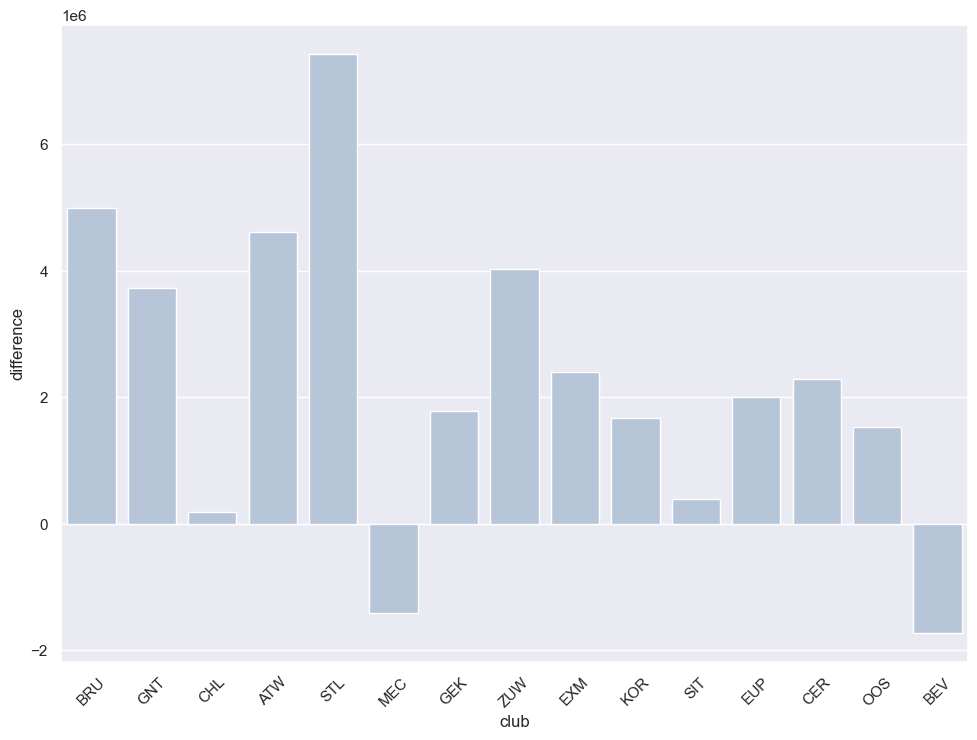

In [96]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=season_2019_df, x="club", y="difference", color="lightsteelblue", ci="sd")
plt.xticks(rotation=45)

- Teams in the graph are in the order of their final season position
- Top teams are overpaying their players significantly more than lower table teams
- Standard Liege is over-paying the most with players being over paid by 7.43M in total
- Mechelen was under-paying for its players and finished in the top 6 suggesting good recuritment stratergy


In [97]:
Difference_in_wage(2019, 'STL')

7430269.428580487

#### Season 2020-2021 

In [98]:
data = []
for club in standings_2020:
    data.append(Difference_in_wage(2020, club))

season_2020_df = pd.DataFrame({"club": standings_2020, "difference": data})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'BRU'),
  Text(1, 0, 'ATW'),
  Text(2, 0, 'AND'),
  Text(3, 0, 'GEK'),
  Text(4, 0, 'OOS'),
  Text(5, 0, 'STL'),
  Text(6, 0, 'GNT'),
  Text(7, 0, 'MEC'),
  Text(8, 0, 'BEE'),
  Text(9, 0, 'ZUW'),
  Text(10, 0, 'LEU'),
  Text(11, 0, 'EUP'),
  Text(12, 0, 'CHL'),
  Text(13, 0, 'KOR'),
  Text(14, 0, 'SIT'),
  Text(15, 0, 'CER'),
  Text(16, 0, 'BEV'),
  Text(17, 0, 'EXM')])

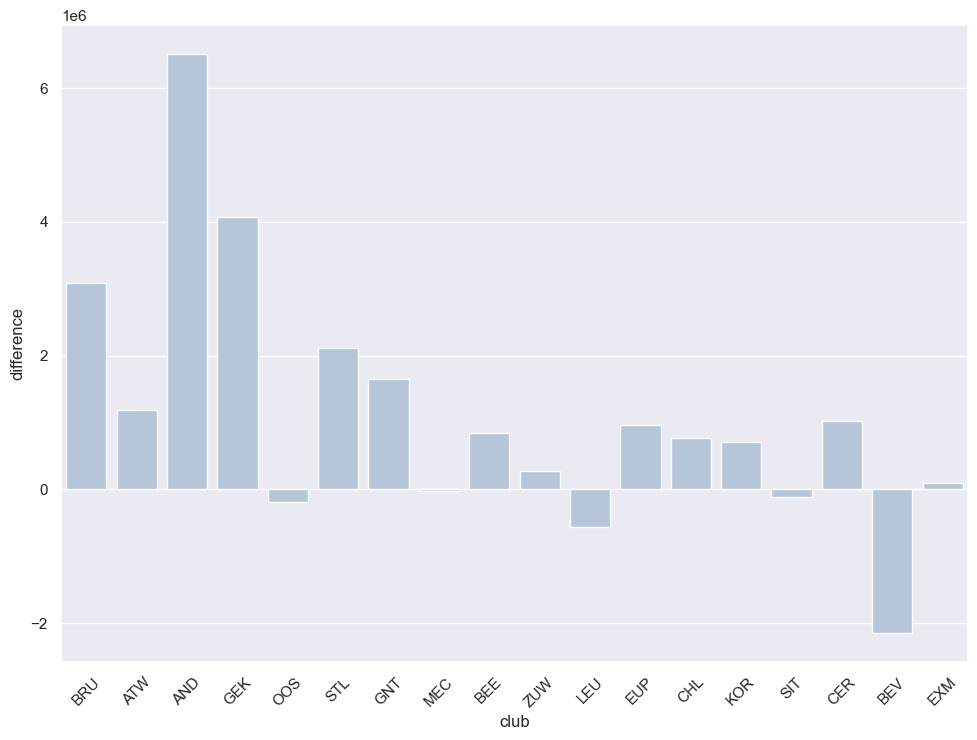

In [99]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=season_2020_df, x="club", y="difference", color="lightsteelblue", ci="sd")
plt.xticks(rotation=45)

In [100]:
df_salary[df_salary['season_id'] == '2019-2020'].salary_gross_eur.sum()-df_salary[df_salary['season_id'] == '2020-2021'].salary_gross_eur.sum()

8520000

In [101]:
Difference_in_wage(2020, 'STL')

2116433.9566517025

- First season with 18 teams: newly promoted OH Leuven is under paying its players and Beerschot is very slightly overpaying     its players
- Beveren, the team that was supposed to relegated is still masively underpaying its players and has finished in a relegation     spot again
- COVID affecting club finances and we can notice clubs cutting down on their wage budgets by 8.52M across the league.(Despite   addition of 2 new teams)
- Simlar trends to previous season:Top teams are overpaying. Anderlecht is overpaying their players the most
- Standard Liege was the fourth most over-paying team (and the mot overpaying team outside the top 4)  with players being over paid by 2.12M in total

#### Season 2021-2022 

In [102]:
data = []
for club in standings_2021:
    data.append(Difference_in_wage(2021, club))

season_2021_df = pd.DataFrame({"club": standings_2021, "difference": data})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'USG'),
  Text(1, 0, 'BRU'),
  Text(2, 0, 'AND'),
  Text(3, 0, 'ATW'),
  Text(4, 0, 'GNT'),
  Text(5, 0, 'CHL'),
  Text(6, 0, 'MEC'),
  Text(7, 0, 'GEK'),
  Text(8, 0, 'SIT'),
  Text(9, 0, 'CER'),
  Text(10, 0, 'LEU'),
  Text(11, 0, 'OOS'),
  Text(12, 0, 'KOR'),
  Text(13, 0, 'STL'),
  Text(14, 0, 'EUP'),
  Text(15, 0, 'ZUW'),
  Text(16, 0, 'SER'),
  Text(17, 0, 'BEE')])

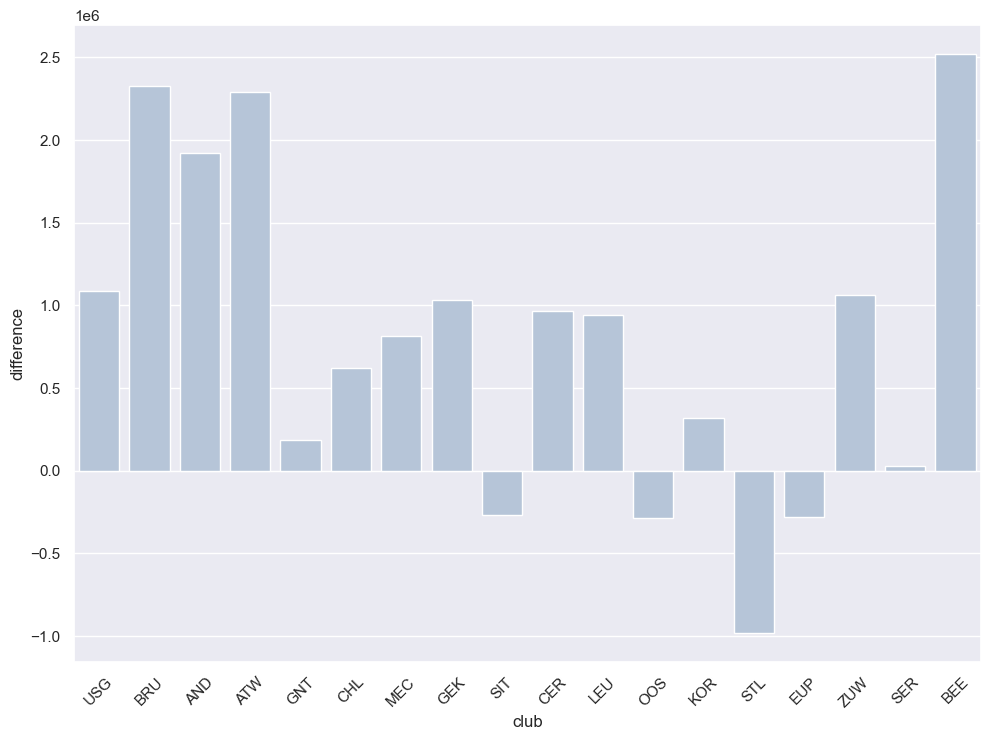

In [103]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=season_2021_df, x="club", y="difference", color="lightsteelblue", ci="sd")
plt.xticks(rotation=45)

In [107]:
Difference_in_wage(2021, 'STL')

-979888.7384953126

- The season in which Standard Liege was accquaired by 777 Partners
- Seraing and Union SG were newely promoted : Belgian giants Union SG returned to the top flight after 48 years and went on to   win the league
- Beerschot were promoted last season and was in the relegation play off last season. They overpaid thier players' the most yet still ended up getting relegated
- Possible change in recruitment stratergy for Standard Liege as they underpaid their player the most by 0.98M, suggesting good negotiation of player wages.

#### Season 2022-2023 

In [104]:
data = []
for club in standings_2022:
    data.append(Difference_in_wage(2022, club))

season_2022_df = pd.DataFrame({"club": standings_2022, "difference": data})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'GEK'),
  Text(1, 0, 'USG'),
  Text(2, 0, 'ATW'),
  Text(3, 0, 'BRU'),
  Text(4, 0, 'GNT'),
  Text(5, 0, 'WES'),
  Text(6, 0, 'STL'),
  Text(7, 0, 'LEU'),
  Text(8, 0, 'CER'),
  Text(9, 0, 'SIT'),
  Text(10, 0, 'AND'),
  Text(11, 0, 'CHL'),
  Text(12, 0, 'MEC'),
  Text(13, 0, 'OOS'),
  Text(14, 0, 'EUP'),
  Text(15, 0, 'ZUW'),
  Text(16, 0, 'KOR'),
  Text(17, 0, 'SER')])

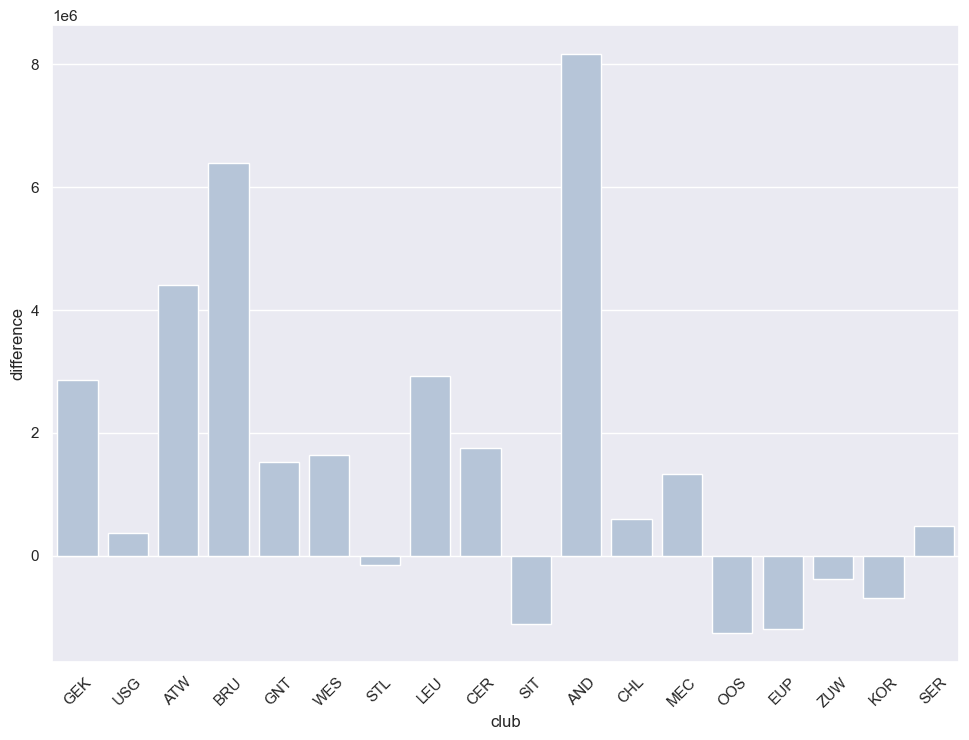

In [105]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=season_2022_df, x="club", y="difference", color="lightsteelblue", ci="sd")
plt.xticks(rotation=45)

In [106]:
Difference_in_wage(2022, 'STL')

-158169.61001949757

- Westerlo was newly promoted and currently they are sitting comfortably in mid-table
- Anderlecht overpaid their players the most by over 8M
- Can notice a consitant recruitment startegy from Standard Liege as it is again  slightly underpaying its players by 158K
- Lower table teams seems to be underpaying their players
